# Pneumonia Detection on Chest X-rays:A Classification Approach

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import cv2

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
datapath = '../../../Datasets/Data_Pneumonia'

In [3]:
# counting the number of files in the image folder
!ls '../../../Datasets/Data_Pneumonia/stage_1_train_images/' | wc -l  

25684


In [4]:
# df_box = pd.read_csv(datapath+'stage_1_train_labels.csv') 
df_box = pd.read_csv("%s" %os.path.join(datapath, 'stage_1_train_labels.csv'))
print('Number of rows (unique boxes per patient) in main train dataset:', df_box.shape[0])
print('Number of unique patient IDs:', df_box['patientId'].nunique())
df_box.head(n = 15)

Number of rows (unique boxes per patient) in main train dataset: 28989
Number of unique patient IDs: 25684


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


Target
0    0.690779
1    0.309221
dtype: float64


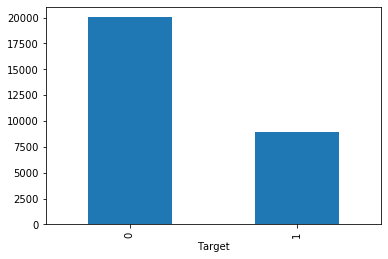

In [5]:
df_box.groupby('Target').size().plot.bar()
print(df_box.groupby('Target').size() / df_box.shape[0])

In [6]:
# df_aux = pd.read_csv(datapath+'stage_1_detailed_class_info.csv')
df_aux = pd.read_csv("%s" %os.path.join(datapath, 'stage_1_detailed_class_info.csv'))
print('Number of rows in auxiliary dataset:', df_aux.shape[0])
print('Number of unique patient IDs:', df_aux['patientId'].nunique())
df_aux.head(6)

Number of rows in auxiliary dataset: 28989
Number of unique patient IDs: 25684


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


### Handle duplicated values

In [7]:
## Handle duplicated values: Analyse duplicated rows to keep the best one
df_box[df_box.duplicated(subset=['patientId'], keep=False)].head(100)

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1
16,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1
19,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1


In [8]:
df_aux[df_aux.duplicated(subset=['patientId'], keep=False)].head(10)

,patientId,class
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
14,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
16,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
19,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity
20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity


In [9]:
## Handle duplicated values: Keep the last row of each duplicated  rows
df_box.drop_duplicates(subset=['patientId'], keep='last', inplace=True)
df_aux.drop_duplicates(subset=['patientId'], keep='last', inplace=True)

# Check duplication
print(df_box[df_box.duplicated(subset=['patientId'], keep=False)].shape)
print(df_aux[df_aux.duplicated(subset=['patientId'], keep=False)].shape)

display(df_box.head())
display(df_aux.head())

(0, 6)
(0, 2)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [10]:
# assert [1,2,3] == [1,2,3], 'Not equal'

class
Lung Opacity                    0.220332
No Lung Opacity / Not Normal    0.447750
Normal                          0.331919
dtype: float64


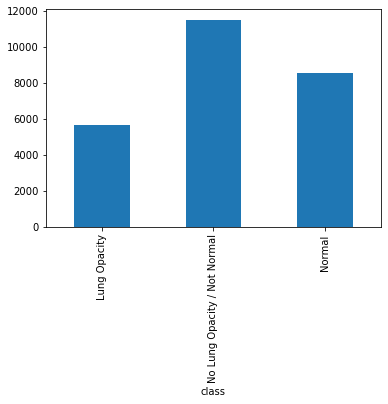

In [11]:
df_aux.groupby('class').size().plot.bar()
print(df_aux.groupby('class').size() / df_aux.shape[0])
assert df_box.loc[df_box['Target']==0].shape[0] == df_aux.loc[df_aux['class'].isin(['Normal', \
    'No Lung Opacity / Not Normal'])].shape[0], 'Number of negative targets does not match between main and auxiliary dataset.'
assert df_box.loc[df_box['Target']==1].shape[0] == df_aux.loc[df_aux['class'] == 'Lung Opacity'].shape[0], \
    'Number of positive targets does not match between main and auxiliary dataset.'

* combine the two dataframes by concatenating their columns.

In [12]:
assert df_box['patientId'].values.tolist() == df_aux['patientId'].values.tolist(), 'PatientId columns are different.'
df_train = pd.concat([df_box, df_aux.drop(labels=['patientId'], axis=1)], axis=1)
df_train.head(6)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [13]:
df_train.groupby(['class', 'Target']).size()

class                         Target
Lung Opacity                  1          5659
No Lung Opacity / Not Normal  0         11500
Normal                        0          8525
dtype: int64

In [14]:
df_train.isnull().any()

patientId    False
x             True
y             True
width         True
height        True
Target       False
class        False
dtype: bool

### Extract all data in the train set that have target labels

From the cell above we can deduce that all data in the train dataset have target labels

* We can also make sure that positive targets are all associated with (non-NaN) box coordinates and viceversa.

In [15]:
# when target==1, are any of the box coordinates null? (should all be false)
df_train.loc[df_train['Target']==1, ['x', 'y', 'width', 'height']].isnull().any()

x         False
y         False
width     False
height    False
dtype: bool

In [16]:
# when target==0, are all of the box coordinates null? (should all be true)
df_train.loc[df_train['Target']==0, ['x', 'y', 'width', 'height']].isnull().all()

x         True
y         True
width     True
height    True
dtype: bool

### Re-label the target variables [0, 0, 1] ---> [0, 1, 2] in both the train (and test data?).

In [17]:
## Re-label the target variables [0, 0, 1] --->> [0, 1, 2] in both the train (and test data?).
df_train['Target'] = np.where(df_train['Target']==1, 2, df_train['Target'])
df_train['Target'] = np.where((df_train['Target']==0)&(df_train['class']=='No Lung Opacity / Not Normal'), 1, df_train['Target'])

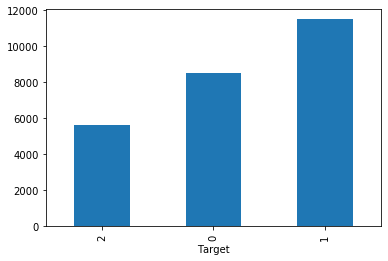

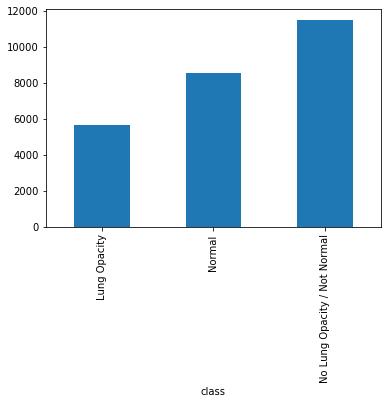

In [18]:
df_train.groupby('Target').size().sort_values().plot.bar()
plt.show()

df_train.groupby('class').size().sort_values().plot.bar()
plt.show()

In [19]:
df_train.to_csv(datapath+'/new/stage_1_train_labels.csv', index=False)

* **Radiograph Images**

* The radiograph images are stored in the folder stage_1_train_images. 
* The images are saved in DICOM format (.dcm), which includes a header of meta-data and the raw pixel image itself. 
* Images are named using their corrsponding patient ID. 
* Images can be read in and modified using the library pydicom. 
* The headers of meta-data have been mostly anonymized for patient privacy, but they still contain a bunch of useful information that could be used to improve the classification model.

* The raw pixel images are stored in 1024x1024 8-bit encoded (2^8=256 gray-scales) numpy arrays.

In [20]:
# sample of image filenames
!ls -U '../../../Datasets/Data_Pneumonia/stage_1_train_images/' | head -10

3360928c-c862-470f-8b08-238114499ce3.dcm
8741ed59-b23a-4b7b-9113-cf359cc2bc41.dcm
454b98c1-3a2d-49a1-bfd3-8e43c3c1ce55.dcm
be379186-93d4-4aa0-b4ae-0c86c9f6b31e.dcm
f609f84e-7834-4854-925e-bb4b883e445a.dcm
d937f102-cf15-4beb-accf-5514beb70f28.dcm
6e66dd4c-d183-42c7-ad77-32abf6ca9760.dcm
a7ea61d4-4c53-46fa-ab3d-043b310de519.dcm
5ae077c7-0d89-49f4-b32d-626adaceada6.dcm
9fb2067e-c64c-428e-8c25-7f50c1f3db42.dcm
ls: write error: Broken pipe


In [21]:
# check that there is an image for each unique patient ID
assert sorted(df_train['patientId'].unique().tolist()) == sorted([f[:-4] for f in os.listdir("%s" %os.path.join(datapath,'stage_1_train_images/'))]), \
    'Discrepancy between patient IDs and radiograph images.'

In [22]:
# have a look at the header meta-data of an image 
pId = df_train['patientId'].sample(2).values[0]    
dcmdata = pydicom.read_file("%s" %os.path.join(datapath,'stage_1_train_images/')+pId+'.dcm')
print(dcmdata)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.18746.1517874413.378595
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'db38a091-c7af-4ef4-a94a-cf2a87e11ea4'
(0010, 0020) Patient ID                          LO: 'db38a091-c7af-4ef4-a94a-cf2a87e11ea4'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

In [23]:
dcmdata.convert_pixel_data

<bound method Dataset.convert_pixel_data of (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.18746.1517874413.378595
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'db38a091-c7af-4ef4-a94a-cf2a87e11ea4'
(0010, 0020) Patient ID                          LO: 'db38a091-c7af-4ef4-a94a-cf2a87e11ea4'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex        

In [24]:
i = 1
(dcmdata.pixel_array.reshape(-1)[1024*i:1024*(i+1)] == dcmdata.pixel_array[i,:]).sum()

1024

In [25]:
dcmdata.pixel_array

array([[2, 2, 2, ..., 3, 2, 1],
       [3, 3, 3, ..., 4, 3, 2],
       [3, 3, 3, ..., 5, 4, 3],
       ...,
       [3, 5, 6, ..., 4, 3, 3],
       [3, 5, 6, ..., 3, 3, 2],
       [1, 3, 4, ..., 3, 2, 1]], dtype=uint8)

In [26]:
# assert dcmdata.pixel_array.reshape(-1)[:1024]==dcmdata.pixel_array[1,:]

In [27]:
dcmdata.PatientAge

'46'

In [28]:
dcmdata.PatientSex

'M'

In [29]:
# extract the raw pixel image and look at its properties
dcmimg = dcmdata.pixel_array
print(type(dcmimg))
print(dcmimg.dtype)
print(dcmimg.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

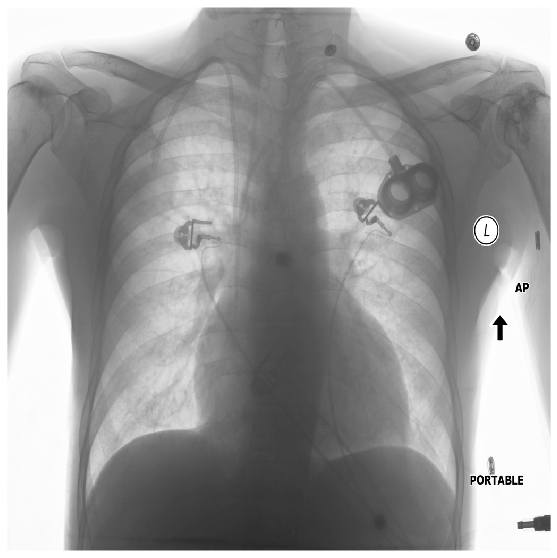

In [30]:
# visualize the corresponding radiograph image
plt.figure(figsize=(20,10))
plt.imshow(dcmimg, cmap=pylab.cm.binary)
plt.axis('off')


In [31]:
def get_boxes_per_patient(df, pId):
    '''
    Given the dataset and one patient ID, 
    return an array of all the bounding boxes and their labels associated with that patient ID.
    Example of return: 
    array([[x1, y1, width1, height1, class1, target1],
           [x2, y2, width2, height2, class2, target2]])
    '''
    
    boxes = df.loc[df['patientId']==pId][['x', 'y', 'width', 'height', 'class', 'Target']].values
    return boxes

def get_dcm_data_per_patient(pId, sample='train'):
    '''
    Given one patient ID and the sample name (train/test), 
    return the corresponding dicom data.
    '''
    return pydicom.read_file("%s" %os.path.join(datapath,'stage_1_')+sample+'_images/'+pId+'.dcm')

def display_image_per_patient(df, pId, angle=0.0, sample='train'):
    '''
    Given one patient ID and the dataset,
    display the corresponding dicom image with overlaying boxes and class annotation.
    To be implemented: Optionally input the image rotation angle, in case of data augmentation.
    '''
    dcmdata = get_dcm_data_per_patient(pId, sample=sample)
    dcmimg = dcmdata.pixel_array
    boxes = get_boxes_per_patient(df, pId)
    plt.figure(figsize=(20,10))
    plt.imshow(dcmimg, cmap=pylab.cm.binary)
    plt.axis('off')
    
    class_color_dict = {'Normal' : 'green',
                        'No Lung Opacity / Not Normal' : 'orange',
                        'Lung Opacity' : 'red'}

    if len(boxes)>0:
        for box in boxes:
            # extracting individual coordinates and labels
            x, y, w, h, c, t = box 
            # create a rectangle patch
            patch = Rectangle((x,y), w, h, color='red', 
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            # get current axis and draw rectangle
            plt.gca().add_patch(patch)
            
    # add annotation text
    plt.text(10, 50, c, color=class_color_dict[c], size=20, 
             bbox=dict(edgecolor=class_color_dict[c], facecolor='none', alpha=0.5, lw=2))

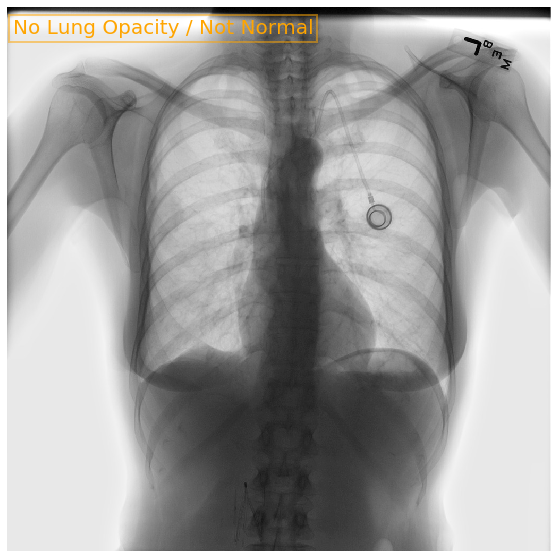

In [32]:
# run this cell multiple times to visualize different examples
pId = df_train['patientId'].sample(1).values[0]    
display_image_per_patient(df_train, pId, sample='train')

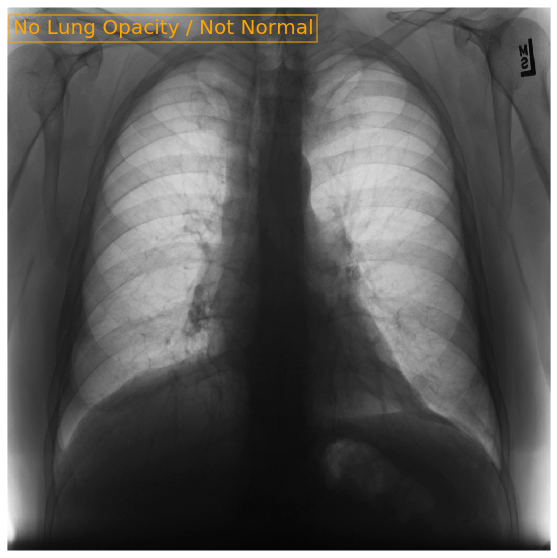

In [33]:
# run this cell multiple times to visualize different examples
pId = df_train['patientId'].sample(1).values[0]    
display_image_per_patient(df_train, pId, sample='train')

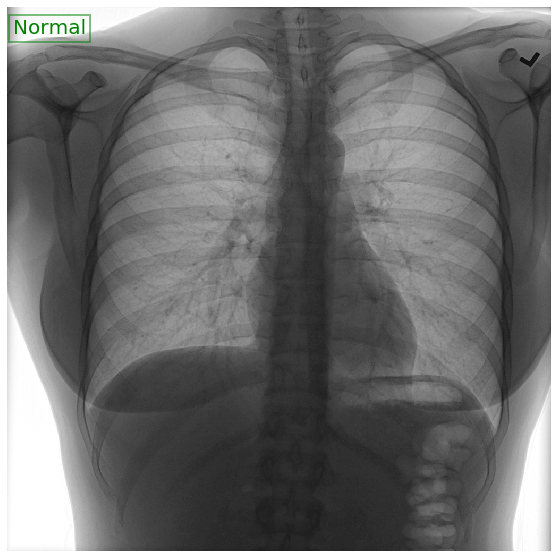

In [34]:
# run this cell multiple times to visualize different examples
pId = df_train['patientId'].sample(1).values[0]    
display_image_per_patient(df_train, pId, sample='train')


In [35]:
def get_metadata_per_patient(pId, attribute, sample='train'):
    '''
    Given a patient ID, return useful meta-data from the corresponding dicom image header.
    Return: 
    attribute value
    '''
    # get dicom image
    dcmdata = get_dcm_data_per_patient(pId, sample=sample)
    # extract attribute values
    attribute_value = getattr(dcmdata, attribute)
    return attribute_value

In [36]:
# # have a look at the header meta-data of an image 
# pId = df_train['patientId'].sample(2).values[0]    
# dcmdata = pydicom.read_file("%s" %os.path.join(datapath,'stage_1_train_images/')+pId+'.dcm')
# print(dcmdata)

In [37]:
# create list of attributes that we want to extract (manually edited after checking which attributes contained valuable information)
attributes = ['PatientSex', 'PatientAge', 'ViewPosition' ]
for a in attributes:
    df_train[a] = df_train['patientId'].apply(lambda x: get_metadata_per_patient(x, a, sample='train'))
# convert patient age from string to numeric
df_train['PatientAge'] = df_train['PatientAge'].apply(pd.to_numeric, errors='coerce')
# remove a few outliers
df_train['PatientAge'] = df_train['PatientAge'].apply(lambda x: x if x<120 else np.nan)
df_train.head()

,patientId,x,y,width,height,Target,class,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,1,No Lung Opacity / Not Normal,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,1,No Lung Opacity / Not Normal,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,1,No Lung Opacity / Not Normal,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,M,28.0,PA
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,2,Lung Opacity,F,32.0,AP


In [38]:
# look at age statistics between positive and negative target groups
# df_train.drop_duplicates('patientId').groupby('Target')['PatientAge'].describe()
df_train.groupby('Target')['PatientAge'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,8522.0,44.860244,16.275091,2.0,33.0,46.0,57.0,90.0
1,11498.0,49.321186,16.468490,1.0,38.0,52.0,61.0,92.0
2,5659.0,45.520410,17.501181,1.0,32.0,47.0,58.0,92.0


In [39]:
# absolute split of view position
df_train.groupby('ViewPosition').size()

ViewPosition
AP    11705
PA    13979
dtype: int64

### Flatten pixel arrays data and store them row-wise in .csv file together with their target labels
#### eg. for image 0 with a target 1

Resized Dimensions :  (64, 64)


(-0.5, 1023.5, 1023.5, -0.5)

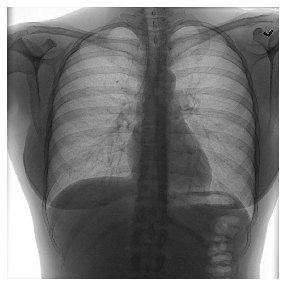

In [40]:
## Resize images from (1024, 1024) to (64,64) using opencv

dim = (64, 64)
# resize image
img= get_dcm_data_per_patient(pId).pixel_array
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

print('Resized Dimensions : ',resized.shape)

plt.figure(figsize=(12, 5))
plt.imshow(img, cmap=pylab.cm.binary)
plt.axis('off')


### Flatten pixel_array

In [41]:
## create a list of the pixel array data flatten and then used it to create a dataframe and finally store 
## the dataframe as csv file

fatten_pixel_list = []

for pId in df_train['patientId'].values:
    img= get_dcm_data_per_patient(pId).pixel_array
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    fatten_pixel_list+= [list(resized.reshape(-1))]


In [42]:
fatten_pixel_array= np.array(fatten_pixel_list, dtype=np.int8)

In [43]:
fatten_pixel_array[0,0]

18

In [44]:
## Store the pixel array into numpy compressed array
np.savez_compressed(datapath+'/paxel_data', pixel_data=fatten_pixel_array)

In [45]:
## Load the pixel array into numpy compressed array
loaded = np.load(datapath+'/paxel_data.npz')
print(np.array_equal(fatten_pixel_array, loaded['pixel_data']))

True


In [46]:
data= pd.DataFrame({
    'patientId':df_train['patientId'], 
    #'pixel_data':fatten_pixel_array, 
    'PatientSex': df_train['PatientSex'], 
    'PatientAge': df_train['PatientAge'], 
    'ViewPosition': df_train['ViewPosition'],
    'class': df_train['class'],
    'target':df_train['Target'] 
})

display(data.head())
# df_train.head()

,patientId,PatientSex,PatientAge,ViewPosition,class,target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51.0,PA,No Lung Opacity / Not Normal,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,F,48.0,PA,No Lung Opacity / Not Normal,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,M,19.0,AP,No Lung Opacity / Not Normal,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,M,28.0,PA,Normal,0
5,00436515-870c-4b36-a041-de91049b9ab4,F,32.0,AP,Lung Opacity,2


In [47]:
##Store the row-wise train data
data.to_csv(datapath+'/stage_1_train_flatten.csv', index=False)


In [48]:
# data.pixel_data.values[0]

### Generate a pie chart showing the percentage of Gender in the train data.

([<matplotlib.patches.Wedge at 0x7fb83970d908>,
 [Text(0.23379794946825708, 1.074866744682539, 'Female'),
  Text(-0.23379805010454371, -1.0748667227927904, 'Male')],
 [Text(0.12752615425541294, 0.5862909516450212, '43.2%'),
  Text(-0.12752620914793292, -0.5862909397051583, '56.8%')])

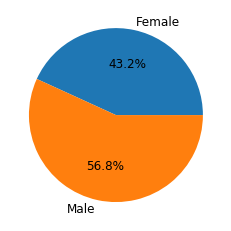

In [49]:
x = data.groupby('PatientSex').patientId.size().rename(index={'F':'Female', 'M': 'Male'})
plt.pie(x,  autopct='%1.1f%%', textprops={'size': 'large'},shadow=False, radius=1., labels=x.index)

### Create a stacked bar chart showing the type of x-ray for the gender

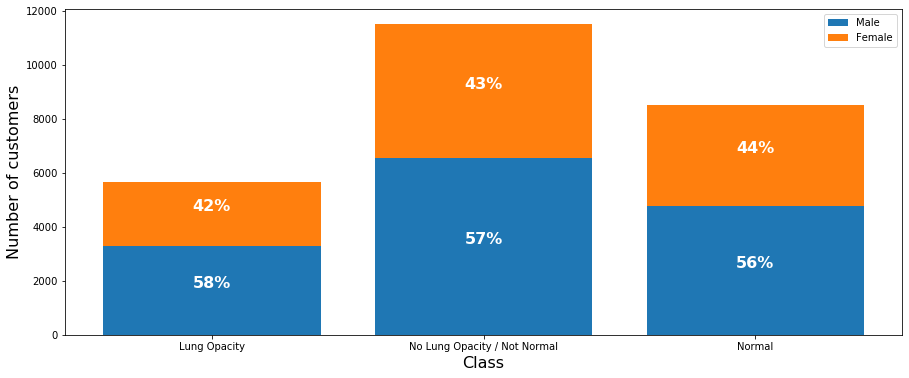

In [50]:
male = data[data.PatientSex=='M'].groupby('class').patientId.size()
female = data[data.PatientSex=='F'].groupby('class').patientId.size()

plt.figure(figsize=(15,6))

ax1= plt.bar(male.index,male,)
ax2= plt.bar(female.index, female, bottom=male)

for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h= h1+h2
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "{:.0%}".format(h1/h), ha="center", va="bottom", color="white", fontsize=16, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "{:.0%}".format(h2/h), ha="center", va="bottom", color="white", fontsize=16, fontweight="bold")

plt.ylabel('Number of customers', fontsize=16)
plt.xlabel('Class', fontsize=16)
plt.legend(['Male', 'Female'] )
plt.title('')
plt.show()

### Histogram plot showing the distribution of gender's age with pneumonia

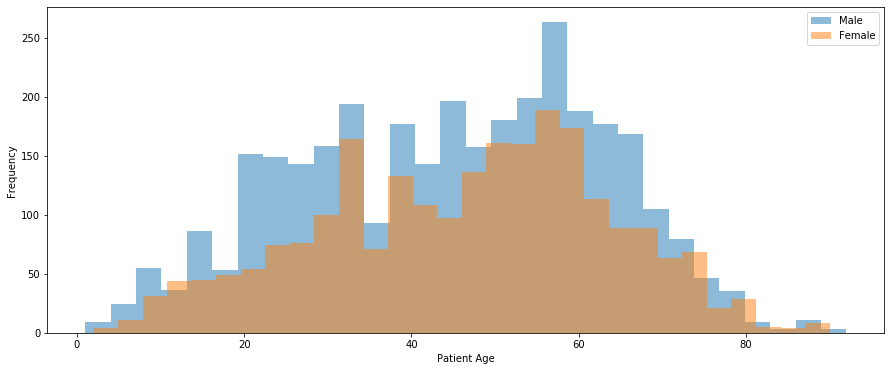

In [51]:
pneumonia= data[data['target']==2]
male = pneumonia[pneumonia.PatientSex=='M'].PatientAge
female = pneumonia[pneumonia.PatientSex=='F'].PatientAge

plt.figure(figsize=(15,6))
plt.hist(male, bins=30, alpha = 0.5)
plt.hist(female, bins=30, alpha = 0.5)
plt.ylabel('Frequency')
plt.xlabel('Patient Age')
plt.legend(['Male', 'Female'])
plt.title('')
plt.show()